Convert a SCHISM conv NetCDF output result to the Ugrid NetCDF format that can be used by D-Eco Impact

In [1]:
#load required libraries and prepare logging
import os
import numpy as np
import xugrid as xu
import xarray as xr
import datetime as dt
import logging


logger = logging.getLogger(__name__)

import sys  
sys.path.insert(1, '../library')
from DEcoImpact_conv_func import DEIModel

#create required functions
def preprocess_schism(ds):
    # convert topology_dimension attribute: str to int
    topodim = int(ds["schism_mesh"].attrs["topology_dimension"])
    mesh_attrs = {"topology_dimension":topodim,
                  "name":"SCHISM_hgrid"}
    ds["schism_mesh"] = ds["schism_mesh"].assign_attrs(mesh_attrs)
    # add necessary attributes for face_node_connectivity
    fnc_attrs = {"_FillValue":-1, "start_index":1}
    ds["SCHISM_hgrid_face_nodes"] = ds["SCHISM_hgrid_face_nodes"].assign_attrs(fnc_attrs)
    # set x/y coords, seems not necessary
    # ds = ds.set_coords(["SCHISM_hgrid_node_x","SCHISM_hgrid_node_y"])
    datavar_attrs = {"mesh":"schism_mesh"}
    for varn in ds.data_vars:
        ds[varn] = ds[varn].assign_attrs(datavar_attrs)
    return ds

def uda_nodes_to_faces(uda_node : xu.UgridDataArray) -> xu.UgridDataArray:
    """
    Credits : J. Veenstra (Deltares)
    https://github.com/Deltares/dfm_tools/blob/a5dd98f73e20d684f0a25a05d4e445a1b00a14b4/dfm_tools/xugrid_helpers.py#L466
    Interpolates a ugrid variable (xu.DataArray) with an node dimension to the faces by averaging the 3/4 nodes around each face.
    Since node variables are mostly defined on interfaces, it also interpolates from interfaces to layers

    Parameters
    ----------
    uda_node : xu.UgridDataArray
        DESCRIPTION.

    Raises
    ------
    KeyError
        DESCRIPTION.

    Returns
    -------
    uda_face : xu.UgridDataArray
        DESCRIPTION.

    """
    
    dimn_faces = uda_node.grid.face_dimension
    dimn_maxfn = 'nMax_face_nodes' #arbitrary dimname that is reduced anyway
    dimn_nodes = uda_node.grid.node_dimension
    fill_value = uda_node.grid.fill_value
    
    if dimn_nodes not in uda_node.sizes:
        raise KeyError(f'varname "{uda_node.name}" does not have an node dimension ({dimn_nodes})')
    
    # construct indexing array
    data_fec = xr.DataArray(uda_node.grid.face_node_connectivity,dims=(dimn_faces,dimn_maxfn))
    data_fec_validbool = data_fec!=fill_value
    data_fec = data_fec.where(data_fec_validbool,-1)
    
    print('node-to-face interpolation: ',end='')
    dtstart = dt.datetime.now()
    # for each face, select all corresponding edge values (this takes some time)
    uda_face_alledges = uda_node.isel({dimn_nodes:data_fec})
    # replace nonexistent edges with nan
    uda_face_alledges = uda_face_alledges.where(data_fec_validbool) #replace all values for fillvalue edges (-1) with nan
    # average edge values per face
    uda_face = uda_face_alledges.mean(dim=dimn_maxfn,keep_attrs=True)
    #update attrs from edge to face
    face_attrs = {'location': 'face', 'cell_methods': f'{dimn_faces}: mean'}
    uda_face = uda_face.assign_attrs(face_attrs)
    print(f'{(dt.datetime.now()-dtstart).total_seconds():.2f} sec')
    
    return uda_face

In [2]:
#configuration
ds_in = r'..\tests\rawdata\schism_output_example.nc' #input location of file that needs to be converted
ds_out = r'input_DEI_schism_output.nc'            #output location of file that can be loaded by D-Eco Impact
crs_code = "epsg:4326"                           #coordinate system applicable to file


In [3]:
#convert the SCHISM format to the UGRID format
mesh2d = xu.open_mfdataset(ds_in, preprocess=preprocess_schism)
print(mesh2d)

<xarray.Dataset> Size: 2MB
Dimensions:              (nSCHISM_hgrid_node: 849, time: 4,
                          nSCHISM_hgrid_face: 1485, nSCHISM_vgrid_layers: 21)
Coordinates:
  * time                 (time) datetime64[ns] 32B 2017-01-03T01:00:00 ... 20...
  * nSCHISM_hgrid_node   (nSCHISM_hgrid_node) int64 7kB 0 1 2 3 ... 846 847 848
  * nSCHISM_hgrid_face   (nSCHISM_hgrid_face) int64 12kB 0 1 2 ... 1483 1484
Dimensions without coordinates: nSCHISM_vgrid_layers
Data variables:
    SCHISM_hgrid_node_x  (nSCHISM_hgrid_node) float64 7kB dask.array<chunksize=(849,), meta=np.ndarray>
    SCHISM_hgrid_node_y  (nSCHISM_hgrid_node) float64 7kB dask.array<chunksize=(849,), meta=np.ndarray>
    depth                (nSCHISM_hgrid_node) float32 3kB dask.array<chunksize=(849,), meta=np.ndarray>
    dryFlagElement       (time, nSCHISM_hgrid_face) float32 24kB dask.array<chunksize=(1, 1485), meta=np.ndarray>
    dryFlagNode          (time, nSCHISM_hgrid_node) float32 14kB dask.array<chunksize=(1,

In [4]:
#Detemine the waterdepth
mesh2d["waterdepth"] = mesh2d["elevation"] - mesh2d["depth"]
mesh2d["waterdepth"] = mesh2d["waterdepth"].assign_attrs({
    "mesh" : "schism_mesh"
    })

In [5]:
#Calculate the overall horizontal flow velocity (based on pythagoram of x and y)
mesh2d["horizontalVel"] = np.sqrt(abs(mesh2d["horizontalVelX"])**2 + abs(mesh2d["horizontalVelY"])**2)
mesh2d["horizontalVel"] = mesh2d["horizontalVel"].assign_attrs({
    "mesh" : "schism_mesh"
    })

In [6]:
#interpolate variables from nodes to faces
# NB. if you have memory issues with writing the final output due to size
# of file in memory you could write and read output in between
#     #write to temporary file (xugrid)
#       mesh2d.ugrid.to_netcdf(ds_tempout)
#       mesh2d = xu.open_mfdataset(ds_tempout)
mesh2d["salinity_face"] = uda_nodes_to_faces(mesh2d["salinity"])
mesh2d["waterdepth_face"] = uda_nodes_to_faces(mesh2d["waterdepth"])
mesh2d["depth_face"] = uda_nodes_to_faces(mesh2d["depth"])
mesh2d["elevation_face"] = uda_nodes_to_faces(mesh2d["elevation"])
mesh2d["temperature_face"] = uda_nodes_to_faces(mesh2d["temperature"])
mesh2d["verticalVelocity_face"] = uda_nodes_to_faces(mesh2d["verticalVelocity"])
mesh2d["horizontalVel_face"] = uda_nodes_to_faces(mesh2d["horizontalVel"])

node-to-face interpolation: 0.05 sec
node-to-face interpolation: 0.13 sec
node-to-face interpolation: 0.05 sec
node-to-face interpolation: 0.05 sec
node-to-face interpolation: 0.04 sec
node-to-face interpolation: 0.05 sec
node-to-face interpolation: 0.03 sec


In [7]:
#Drop no longer required variables:
drop_variables = ["salinity", "waterdepth","depth","elevation",\
                  "temperature","verticalVelocity","horizontalVel"]
mesh2d = mesh2d.drop_vars(drop_variables)

In [8]:
#initialize
DEI = DEIModel()
cwd = os.getcwd()
DEI.set_root(root = cwd)



#read Netcdf
DEI._mesh2d = mesh2d


#export result
DEI.write_mesh(fn_temp = "example_output_data/temporary_file.nc", fn_ecoimpact = "example_output_data/"+ds_out)

print("Done.")

Done.


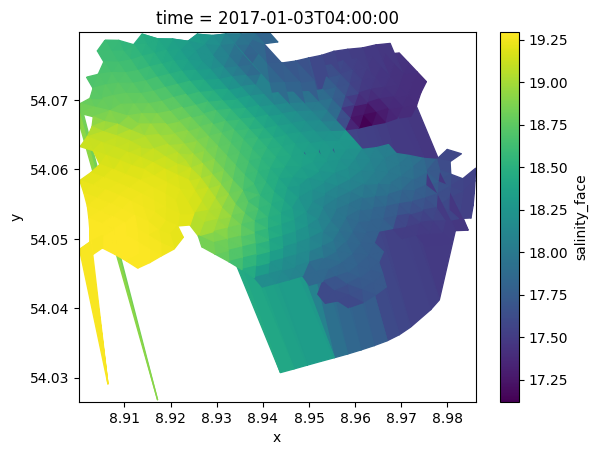

In [10]:
#visualize results
with xu.open_mfdataset("example_output_data/"+ds_out) as result:
    result["salinity_face"].sel(time= "2017-01-03 04:00:00" , nSCHISM_vgrid_layers = 1).ugrid.plot()